# Generate a few gene lists

There are a couple of ways to assess the similarity of gene lists:

- If most of the genes in the entire list are relevant, it makes sense to compare one ranked list of genes with another. A Kendall tau correlation can do that.

- If only a few of the genes in a list are likely to be relevant, the noise of the many will drown out the signal of the few. In this case, it is probably best to determine how likely the few important genes in one list are to be important in the other. Background genes would be ignored in this case.

Here, we generate a few lists to support those comparisons. Our main results are comparisons between HCP connectivity data and AHBA gene expression data. We generate a list for each distance mask used.

In [61]:
""" Define some lists for looping. """
masks = ['00', '16', '32', '64', ]
shuffles = ["none", "agno", "dist", "edge", ]

## This section determines the threshold for how many ranked genes to use in ermineJ.

The average peak during training leaves about 70 genes beyond the peak. So, for thresholding the ranked gene lists, taking the top 70 will be about the same as taking the genes surviving beyond the peak. When averaging rankings across split-halves, each split-half run will peak at a different place. So there is no way to have an actual specific peak in averaged data.

In [2]:
""" Load up the data, preprocessed by the ge_data_manager project.
    We won't use this to generate rankings, but we can see quickly
    where the peaks are in each run. """

import pickle

pre_calc_results = {}
for mask in masks:
    with open("/data/plots/cache/hcpww{}speak_ol_post.df".format(mask), "br") as f:
        pre_calc_results[mask] = pickle.load(f)
        derivatives = pre_calc_results[mask][pre_calc_results[mask]['shuffle'] == 'none']
        print("Peak for {} at {:,} +/- {:0.0f}".format(
            mask,
            15745 - int(derivatives['peak'].mean()),
            derivatives['peak'].std(),
        ))
        for shuf in ["agno", "dist", "edge", ]:
            shuffles = pre_calc_results[mask][pre_calc_results[mask]['shuffle'] == shuf]
            print("     {} {} at {:,} +/- {:0.0f}".format(
                mask, shuf,
                15745 - int(shuffles['peak'].mean()),
                shuffles['peak'].std(),
            ))


Peak for 00 at 72 +/- 18
     00 agno at 88 +/- 25
     00 dist at 79 +/- 24
     00 edge at 45 +/- 12
Peak for 16 at 72 +/- 14
     16 agno at 89 +/- 25
     16 dist at 79 +/- 24
     16 edge at 46 +/- 12
Peak for 32 at 77 +/- 14
     32 agno at 90 +/- 25
     32 dist at 78 +/- 23
     32 edge at 46 +/- 13
Peak for 64 at 69 +/- 17
     64 agno at 89 +/- 26
     64 dist at 78 +/- 23
     64 edge at 49 +/- 14


## This section recalculates rankings and p-values for a different cut-off

Another way to determine which genes are "relevant" is to calculate a p-value for each gene's ranking vs the same gene's ranking in shuffled data.

In [3]:
""" Modified from ge_data_manager to include shuffled data,
    the ranked_probes function iterates over result tsvs, ranking genes and saving them
    into a single dataframe. """

import pandas as pd
from pygest import algorithms
from pygest.convenience import bids_val
from pygest.rawdata import miscellaneous


def name_from_path(path):
    """ Extract critical pieces from the path to return an abbreviated column name.
        Three items differ in each path: 4 shuffle-types, 16 splits, 16 seeds (plus None). """
    
    shuf = bids_val("shuffle", path)
    if shuf == "random":
        shuf = "agno" 
    if shuf == "actual":
        shuf = "real" 
    
    batch = bids_val("batch", path)[-3:]
    seed = bids_val("seed", path)[-3:]
    
    return "{}-{}-{}".format(shuf, batch, seed)

    
def ranked_probes(tsvs, top):
    """ Go through the files provided, at the threshold specified, and report probes in all files. """

    report_progress_on_items = range(int(len(tsvs)/10), len(tsvs), int(len(tsvs)/10))
    all_rankings = pd.DataFrame()
    for i, tsv in enumerate(tsvs):
        df = pd.read_csv(tsv, sep='\t')
        rankings = pd.Series(data=df.index, index=df['probe_id'], name=name_from_path(tsv))
        if i == 0:
            all_rankings = pd.DataFrame(data=rankings)
        else:
            all_rankings[rankings.name] = rankings
        # if i in report_progress_on_items:
        #     print("Ranked {} of {} and counting...".format(i, len(tsvs)))
        if i == len(tsvs):
            print("    ranked all probes in {} results.".format(i + 1))
    all_rankings['mean'] = all_rankings.mean(axis=1)
    all_rankings['entrez_id'] = all_rankings.index.map(miscellaneous.map_pid_to_eid_fornito)
    return all_rankings.sort_values('mean', ascending=True)


In [4]:
""" Rank probes/genes for each and every run. """

rankings = {}
for mask in masks:
    tsv_files = pre_calc_results[mask]['path']
    rankings[mask] = ranked_probes(tsv_files, None)

In [5]:
""" Determine, for each probe/gene, how likely it is for a real ranking to be higher than a shuffled ranking. """

import numpy as np

def p_probe(probe_id, df):
    """ Return probability (p-value) a real rank is higher than shuffled. """
    
    ps = {}
    real_runs = [c for c in df.columns if "real" in c]
    for shuf in ["agno", "dist", "edge", ]:
        shuffled_runs = [c for c in df.columns if shuf in c]

        n_better = 0
        n_worse = 0
        n_total = 0
        for real in df.loc[probe_id, real_runs]:
            for baseline in df.loc[probe_id, shuffled_runs]:
                n_total += 1
                if real < baseline:
                    n_better += 1
                else:
                    n_worse += 1
            # print("    {} vs {} of {}".format(n_better, n_worse, n_total))
        ps[shuf] = n_worse / n_total

        # print("Mean real rank = {:,} vs mean {} rank of {:,}; {:,} better, {:,} worse, out of {:,}; p = {:0.3f}".format(
        #     int(np.mean(df.loc[probe_id, real_runs])), shuf, int(np.mean(df.loc[probe_id, shuffled_runs])),
        #     n_better, n_worse, n_total, ps[shuf]
        # ))
        
    return ps["agno"], ps["dist"], ps["edge"]

In [86]:
""" Manually sample a few genes that came out in the prior algorithm as good, ok, and bad.
    Use just this small subset to rapidly prototype and check old vs new algorithms. """ 

selected_ids = [57622, 8178, 728882, 10605, 23395, 1482, 9865, ]
selected_ids = set(selected_ids).union(set(rankings["16"].sample(16)['entrez_id']))
selected_probes = list(rankings["16"][rankings["16"]["entrez_id"].isin(selected_ids)]["entrez_id"].index)
# selected_probes

In [87]:
""" Calculate p-values for real vs each of three shuffle types.
    This employs the c-style time intenstive process that performs ~4000 comparisons per gene. """

import pandas as pd

df_p_values = {}
for mask in ["16", ]: # TODO: replace me with masks:
    p_values = {}
    print("Calculating p-values for {}mm-masked results.".format(mask))
    for pid in selected_probes:  # TODO: replace me with rankings[mask].index:
        p_a, p_d, p_e = p_probe(pid, rankings[mask])
        p_values[pid] = {
            'entrez_id': int(rankings[mask].loc[pid, 'entrez_id']),
            'old_agno': p_a,
            'old_dist': p_d,
            'old_edge': p_e,
        }
    df_p_values[mask] = pd.DataFrame(data=p_values).T
    df_p_values[mask]['entrez_id'] = df_p_values[mask]['entrez_id'].astype(int)
    # df_p_values[mask] = df_p_values[mask].set_index('entrez_id')


Calculating p-values for 16mm-masked results.


In [88]:
import numpy as np

mask = "16"

reals = rankings[mask].loc[selected_probes, [x for x in rankings[mask].columns if "real" in x]]
real_means = reals.apply(np.mean, axis=1)

for shuffle in ["agno", "dist", "edge"]:
    permuted_rankings = rankings[mask].loc[selected_probes, [x for x in rankings[mask].columns if shuffle in x]]
    hits = permuted_rankings.lt(real_means, axis=0)
    df_p_values[mask]['new_' + shuffle] = hits.sum(axis=1) / hits.count(axis=1)


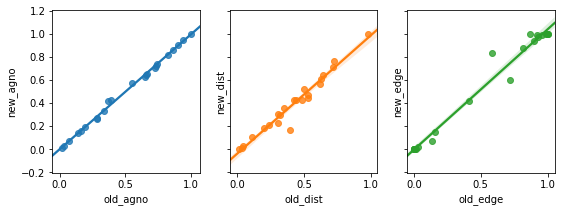

In [91]:
import seaborn as sns

fig, axes = plt.subplots(ncols=3, figsize=(9,3), sharey=True)
sns.regplot(x="old_agno", y="new_agno", data=df_p_values["16"], ax=axes[0])
sns.regplot(x="old_dist", y="new_dist", data=df_p_values["16"], ax=axes[1])
sns.regplot(x="old_edge", y="new_edge", data=df_p_values["16"], ax=axes[2])
fig.savefig("./old_vs_new_p.png")

In [71]:
""" Define a kernel-density plot to assist in visualizing the distributions of rankings. """

import seaborn as sns
import matplotlib.pyplot as plt

flatten = lambda l: [x for y in l for x in y]

def plot_entrez_id(entrez_id, rank_data, p_data):
    """ Plot ranking distributions for one entrez id. """
    fig, ax = plt.subplots()
    real_list = flatten(rank_data[rank_data['entrez_id'] == entrez_id][[x for x in rank_data.columns if "real" in x]].values)
    real_label = "real"
    sns.distplot(real_list, ax=ax, kde_kws={"color": "black", "label": real_label}, hist_kws={"color": "gray"})
    agno_list = flatten(rank_data[rank_data['entrez_id'] == entrez_id][[x for x in rank_data.columns if "agno" in x]].values)
    agno_label = "vs agno, p = {:0.5f}".format(p_data.loc[entrez_id, 'agno'])
    sns.distplot(agno_list, ax=ax, kde_kws={"color": "green", "label": agno_label}, hist_kws={"color": "lightgreen"})
    dist_list = flatten(rank_data[rank_data['entrez_id'] == entrez_id][[x for x in rank_data.columns if "dist" in x]].values)
    dist_label = "vs dist, p = {:0.5f}".format(p_data.loc[entrez_id, 'dist'])
    sns.distplot(dist_list, ax=ax, kde_kws={"color": "red", "label": dist_label}, hist_kws={"color": "mistyrose"})
    edge_list = flatten(rank_data[rank_data['entrez_id'] == entrez_id][[x for x in rank_data.columns if "edge" in x]].values)
    edge_label = "vs edge, p = {:0.5f}".format(p_data.loc[entrez_id, 'edge'])
    sns.distplot(edge_list, ax=ax, kde_kws={"color": "magenta", "label": edge_label}, hist_kws={"color": "lavenderblush"})
    fig.suptitle("Entrez ID {}".format(entrez_id))
    return fig, ax

# f, a = plot_entrez_id(57622, rankings["16"], df_p_values["16"].set_index('entrez_id'))

In [9]:
""" Save out a csv file with entrez ids ordered by p-value for each mask and shuffle type. """

import random

for mask in masks:
    eids_all_good = set(df_p_values[mask]['entrez_id'])
    eids_all_bad = set(df_p_values[mask]['entrez_id'])
    for shuf in ['agno', 'dist', 'edge', ]:
        df = df_p_values[mask][['entrez_id', shuf]].set_index('entrez_id').sort_values(shuf)
        df = df.rename(columns={shuf: "p"})
        print("{} {} {:,} probes with p < 0.05".format(mask, shuf, (df['p'] < 0.05).sum()))
        df.to_csv("./hcpww{}s_{}_p.csv".format(mask, shuf))
        
        eids_all_good = eids_all_good.intersection(set(df['p'][df['p'] < 0.05].index))
        eids_all_bad = eids_all_bad.intersection(set(df['p'][df['p'] >= 0.05].index))

    print("Mask {} has {} probes surviving all tests.".format(mask, len(eids_all_good)))
    print("    {}".format(sorted(list(eids_all_good))[:12]))
    eid_to_plot = random.sample(eids_all_good, 1)[0]
    f, a = plot_entrez_id(eid_to_plot, rankings[mask], df_p_values[mask].set_index('entrez_id'))
    f.savefig("good_{}_{}.png".format(mask, eid_to_plot))
    f.clear()
    
    print("Mask {} has {} probes failing all tests.".format(mask, len(eids_all_bad)))
    print("    {}".format(sorted(list(eids_all_bad))[:12]))
    eid_to_plot = random.sample(eids_all_bad, 1)[0]
    f, a = plot_entrez_id(eid_to_plot, rankings[mask], df_p_values[mask].set_index('entrez_id'))    
    f.savefig("bad_{}_{}.png".format(mask, eid_to_plot))
    f.clear()


00 agno 331 probes with p < 0.05
00 dist 11 probes with p < 0.05
00 edge 2,441 probes with p < 0.05
Mask 00 has 6 probes surviving all tests.
    [9607, 9734, 10451, 10714, 57622, 80036]
Mask 00 has 13112 probes failing all tests.
    [1, 2, 12, 14, 16, 18, 19, 20, 21, 22, 23, 25]
16 agno 333 probes with p < 0.05
16 dist 10 probes with p < 0.05
16 edge 2,404 probes with p < 0.05
Mask 16 has 5 probes surviving all tests.
    [9607, 9734, 10451, 57622, 80036]
Mask 16 has 13140 probes failing all tests.
    [1, 2, 12, 14, 16, 18, 19, 20, 21, 22, 23, 25]
32 agno 331 probes with p < 0.05
32 dist 12 probes with p < 0.05
32 edge 2,319 probes with p < 0.05
Mask 32 has 5 probes surviving all tests.
    [9607, 9734, 57622, 80036, 171019]
Mask 32 has 13228 probes failing all tests.
    [1, 2, 12, 14, 16, 18, 19, 20, 21, 22, 23, 25]
64 agno 333 probes with p < 0.05
64 dist 9 probes with p < 0.05
64 edge 1,954 probes with p < 0.05
Mask 64 has 4 probes surviving all tests.
    [9607, 9734, 57622, 80

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>